In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, glob, os, warnings
from cv2 import blur as box_filter

warnings.filterwarnings("ignore")

In [6]:
gt_path = r".\Dataset\I-HAZE\I-HAZY NTIRE 2018\GT/02_indoor_GT.jpg"
hazy_img_path = r".\Dataset\I-HAZE\I-HAZY NTIRE 2018\hazy/02_indoor_hazy.jpg"

#### Dark Channel prior

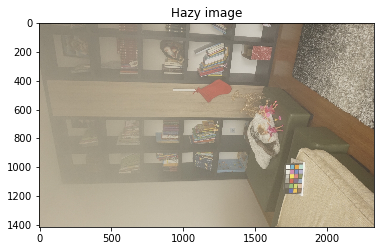

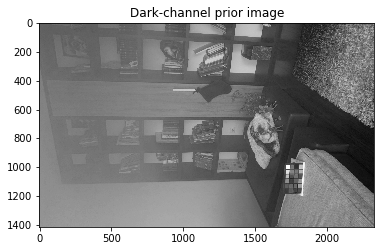

In [3]:
patch_size = 15

def get_min_value_patch_channel(img, rows, columns, patch_size):
    min_channel = np.zeros((rows, columns))
    for row in range(rows):
        for col in range(columns):
            min_channel[row - patch_size // 2][col - patch_size // 2] = np.min(img[row, col, :])
    return min_channel


def get_min_value_patch_whole(img, min_channel, rows, columns, patch_size):
    dark_channel = np.zeros((hazy_img.shape[0], hazy_img.shape[1]))
    for row in range(patch_size // 2, rows - patch_size // 2):
        for col in range(patch_size // 2, columns - patch_size // 2):
            dark_channel[row - patch_size // 2][col - patch_size // 2] = np.min(min_channel[row - patch_size // 2:row + patch_size // 2, col - patch_size // 2:col + patch_size // 2])
    return dark_channel


def dark_channel_prior(img, patch_size):
    dark_channel = np.zeros((img.shape[0], img.shape[1]))
    img = cv2.copyMakeBorder(img, patch_size // 2, patch_size // 2, patch_size // 2, patch_size // 2,
                             cv2.BORDER_CONSTANT,
                             value=[255, 255, 255])
    no_rows, no_cols = img.shape[0], img.shape[1]

    # min pixel value in patch among channel-wise
    min_channel = get_min_value_patch_channel(img, no_rows, no_cols, patch_size)
    # min pixel value in patch after min_channel
    dark_channel = get_min_value_patch_whole(img, min_channel, no_rows, no_cols, patch_size)
    return dark_channel


hazy_img = cv2.imread(hazy_img_path)
hazy_img = cv2.resize(hazy_img, (0, 0), fx=0.5, fy=0.5)

# plt.figure(figsize=(10, 10))
plt.imshow(hazy_img[:, :, ::-1])
plt.title('Hazy image')
plt.show()


dark_channel_img = dark_channel_prior(hazy_img, patch_size)
dark_channel_img = dark_channel_img.astype('uint8')

# plt.figure(figsize=(10, 10))
plt.imshow(dark_channel_img, 'gray')
plt.title('Dark-channel prior image')
plt.show()

### atmospheric light - A

In [4]:
def get_atm_light(h_img, dark_channel_img):
    print(dark_channel_img.shape)
    img = h_img.copy()
    num_pixels = dark_channel_img.size
    print('#pixels:', num_pixels)

    num_brightest = num_pixels // 1000  # 0.1% from paper
    print('%pixels taking:', num_brightest)

    # getting indices of brightest pixels in the deep-channel image and Indices sorted based on corresponding pixel values in Descending order
    haze_brightness_sort_indices = np.argsort(dark_channel_img, axis=None)[::-1]
    print('Descending order:', haze_brightness_sort_indices)

    brightest_indices = haze_brightness_sort_indices[0:num_brightest]  # top 0.1% =3296
    print(brightest_indices)

    brightest_indices = np.unravel_index(brightest_indices, dark_channel_img.shape)
    print(brightest_indices)

    brightest_pixels = img[brightest_indices]  # selecting the pixels in hazy images
    print(brightest_pixels[0])

    top_intensities = np.average(brightest_pixels, axis=1)  # channel wise avg of selected pixel values
    print(top_intensities)

    max_intensity_index = np.argmax(top_intensities)  # index of max_intensity pixel among selected pixels
    print(max_intensity_index)

    A = brightest_pixels[max_intensity_index]  # A = global atmospheric light

    return A

In [5]:
atm_light = get_atm_light(hazy_img, dark_channel_img)

atm_light

(1416, 2328)
#pixels: 3296448
%pixels taking: 3296
Descending order: [2374068 2395019 2402003 ... 1662154 1659826 1659825]
[2374068 2395019 2402003 ... 2560311 2385604 2257669]
(array([1019, 1028, 1031, ..., 1099, 1024,  969], dtype=int64), array([1836, 1835, 1835, ..., 1839, 1732, 1837], dtype=int64))
[238 240 241]
[239.66666667 238.         238.33333333 ... 232.33333333 221.66666667
 223.        ]
26


array([236, 245, 249], dtype=uint8)

### Transmission Map

In [6]:
tBar = dark_channel_prior(hazy_img / atm_light, 15)

In [7]:
tBar.shape

(1416, 2328)

In [8]:
omega = 0.85  # min haze factor
transBar = 1 - (omega * tBar)

In [9]:
transBar.shape

(1416, 2328)

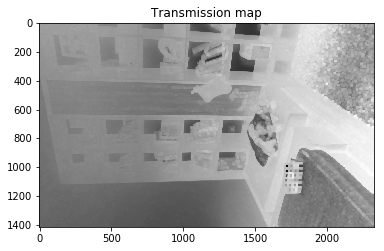

In [16]:
plt.imshow(transBar, 'gray')
plt.title('Transmission map')
plt.show()

### final recovered image

0.1807228915662651


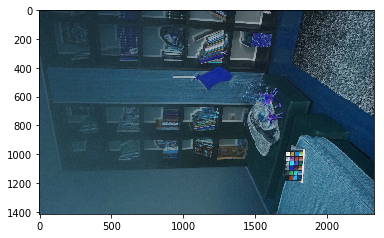

In [13]:
def final_recovered_image(img, transmissionMap, atm_light, t0):
    trans_recover = np.copy(transmissionMap)
    print(np.min(trans_recover))
    trans_recover[trans_recover < t0] = t0  # clipping the values --> max(t1, t0)
    finalImage = np.zeros((img.shape))  # reconstruction img from formula
    channels = 3
    for ch in range(channels):
        finalImage[:, :, ch] = ((img[:, :, ch] - atm_light[ch]) / trans_recover) + atm_light[ch]
    return finalImage


haz_img = hazy_img.astype("double")
finalImage = final_recovered_image(haz_img, transBar, atm_light, 0.1)
finalImage = ((finalImage - np.min(finalImage)) / (np.max(finalImage) - np.min(finalImage))) * 255

plt.imshow((np.uint8(finalImage)))
plt.show()

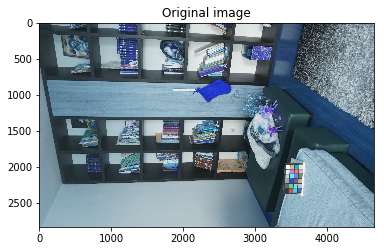

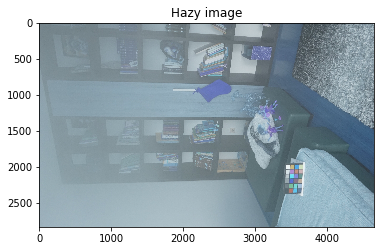

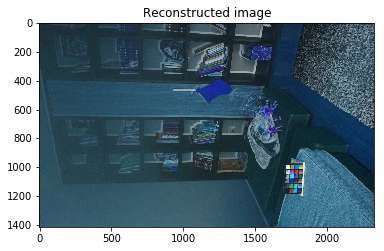

In [14]:
original_img =  cv2.imread(gt_path)
plt.imshow(original_img)
plt.title('Original image')
plt.show()

original_hazy_img = cv2.imread(hazy_img_path)
plt.imshow(original_hazy_img)
plt.title('Hazy image')
plt.show()

plt.imshow((np.uint8(finalImage)))
plt.title('Reconstructed image')
plt.show()